In [109]:
import gymnasium as gym
import numpy as np

import matplotlib.pyplot as plt

In [110]:
def moving_average(values, window):
    weights = np.ones(window) / window
    return np.convolve(values, weights, mode='valid')

In [173]:
env = gym.make('FrozenLake-v1')
gamma = 0.99

nS = env.observation_space.n
nA = env.action_space.n

eval_iter = 200
eval_episodes = 100
log_iter = 10000

# SARSA

In [174]:
def SARSA(total_steps, alpha, epsilon, alpha_decay, epsilon_decay):
    alpha_start = alpha
    epsilon_start = epsilon

    alpha = alpha_start
    epsilon = epsilon_start

    pi = np.ones([nS, nA]) * 0.25
    Q = np.zeros([nS, nA])

    def eval(num_episodes):
        returns = 0
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            ep_return = 0

            while not done:
                best_actions = np.where(Q[obs] == np.max(Q[obs]))[0]
                act = np.random.choice(best_actions)

                obs, rew, terminated, truncated, _ = env.step(act)
                done = terminated or truncated
                ep_return += rew
                
            returns += ep_return
        
        return returns/num_episodes

    eval_rets = []

    steps = 0
    while steps < total_steps:
        obs, _ = env.reset()
        a = np.random.choice(range(nA), p=pi[obs])

        while True:
            next_obs, r, terminated, truncated, _ = env.step(a)
            next_a = np.random.choice(range(nA), p=pi[next_obs])
            steps += 1

            Q[obs, a] = Q[obs, a] + alpha * (r + gamma * Q[next_obs, next_a] - Q[obs, a])

            best_actions = np.where(Q[obs] == np.max(Q[obs]))[0]
            best_a = np.random.choice(best_actions)
            
            for a in range(nA):
                if a != best_a:
                    pi[obs, a] = epsilon/nA
                else:
                    pi[obs, a] = epsilon/nA + (1 - epsilon)
            
            alpha = max(alpha-1/alpha_decay*alpha_start, 0)
            epsilon = max(epsilon-(1/epsilon_decay)*epsilon_start, 0)

            if steps % eval_iter == 0:
                score = eval(eval_episodes)
                eval_rets.append(score)

            #if steps % log_iter == 0:
            #    print("steps={}. score={}".format(steps, eval_rets[-1]))

            if terminated or truncated:
                break
            elif steps >= total_steps:
                break
            else:
                obs = next_obs
                a = next_a
    
    return eval_rets

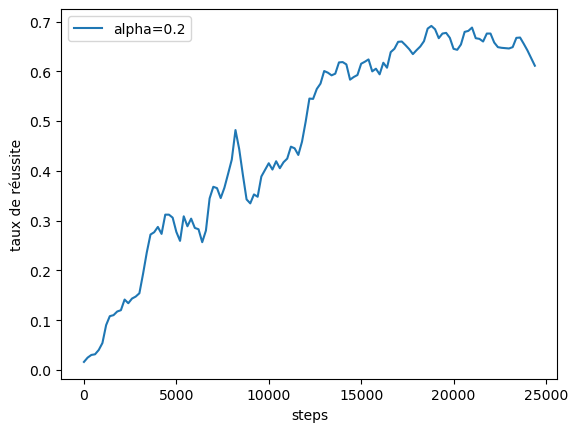

In [210]:
alphas = [0.2]

for alpha in alphas:
    eval_rets_total = [0] * (25000//eval_iter)

    for _ in range(5):
        eval_rets = SARSA(total_steps=25000, alpha=alpha, epsilon=0.5, alpha_decay=25000, epsilon_decay=25000)
        eval_rets_total = [a+b for (a,b) in zip(eval_rets_total, eval_rets)]

    eval_rets_total = [a/5 for a in eval_rets_total]
    
    moving_avg_window = 3
    to_plot = moving_average(eval_rets_total, moving_avg_window)
    plt.plot([eval_iter*step_iter for step_iter in range(len(to_plot))], to_plot, label="alpha={}".format(alpha))
    plt.xlabel('steps')
    plt.ylabel('taux de réussite')
    plt.legend()
    plt.savefig('frozenlake_sarsa.png', dpi=600)

# Q-learning

In [204]:
def qlearning(total_steps, alpha, epsilon, alpha_decay, epsilon_decay):
    alpha_start = alpha
    epsilon_start = epsilon

    alpha = alpha_start
    epsilon = epsilon_start

    pi = np.ones([nS, nA]) * 0.25
    Q = np.zeros([nS, nA])

    def eval(num_episodes):
        returns = 0
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            ep_return = 0

            while not done:
                best_actions = np.where(Q[obs] == np.max(Q[obs]))[0]
                act = np.random.choice(best_actions)

                obs, rew, terminated, truncated, _ = env.step(act)
                done = terminated or truncated
                ep_return += rew
                
            returns += ep_return
        
        return returns/num_episodes

    eval_rets = []

    steps = 0
    while steps < total_steps:
        obs, _ = env.reset()
        a = np.random.choice(range(nA), p=pi[obs])

        while True:
            next_obs, r, terminated, truncated, _ = env.step(a)
            next_a = np.random.choice(range(nA), p=pi[next_obs])
            steps += 1

            Q[obs, a] = Q[obs, a] + alpha * (r + gamma * np.max(Q[next_obs]) - Q[obs, a])

            best_actions = np.where(Q[obs] == np.max(Q[obs]))[0]
            best_a = np.random.choice(best_actions)
            
            for a in range(nA):
                if a != best_a:
                    pi[obs, a] = epsilon/nA
                else:
                    pi[obs, a] = epsilon/nA + (1 - epsilon)
            
            alpha = max(alpha-1/alpha_decay*alpha_start, 0)
            epsilon = max(epsilon-(1/epsilon_decay)*epsilon_start, 0)

            if steps % eval_iter == 0:
                score = eval(eval_episodes)
                eval_rets.append(score)

            #if steps % log_iter == 0:
            #    print("steps={}. score={}".format(steps, eval_rets[-1]))

            if terminated or truncated:
                break
            elif steps >= total_steps:
                break
            else:
                obs = next_obs
                a = next_a
    
    return eval_rets

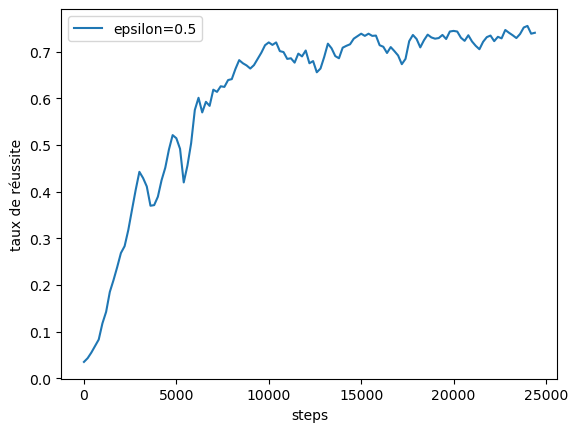

In [209]:
epsilons = [0.5]

for epsilon in epsilons:
    eval_rets_total = [0] * (25000//eval_iter)

    for _ in range(5):
        eval_rets = qlearning(total_steps=25000, alpha=0.2, epsilon=epsilon, alpha_decay=25000, epsilon_decay=25000)
        eval_rets_total = [a+b for (a,b) in zip(eval_rets_total, eval_rets)]

    eval_rets_total = [a/5 for a in eval_rets_total]
    
    moving_avg_window = 3
    to_plot = moving_average(eval_rets_total, moving_avg_window)
    plt.plot([eval_iter*step_iter for step_iter in range(len(to_plot))], to_plot, label="epsilon={}".format(epsilon))
    plt.xlabel('steps')
    plt.ylabel('taux de réussite')
    plt.legend()
    plt.savefig('frozenlake_qlearning.png', dpi=600)